In [ ]:
import yfinance as yf

data = yf.download('TCS.NS')
data = data['Close']

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data

Date
2002-08-12      39.700001
2002-08-13      39.162498
2002-08-14      36.462502
2002-08-15      36.462502
2002-08-16      36.375000
                 ...     
2024-07-04    4020.949951
2024-07-05    4011.800049
2024-07-08    3993.199951
2024-07-09    3985.500000
2024-07-10    3909.149902
Name: Close, Length: 5439, dtype: float64

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Create sequences for the GRU model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(GRU(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
108/108 [==============================] - 11s 65ms/step - loss: 8.3655e-04 - val_loss: 1.0011e-04
Epoch 2/50
108/108 [==============================] - 7s 68ms/step - loss: 1.5863e-05 - val_loss: 9.5017e-05
Epoch 3/50
108/108 [==============================] - 6s 56ms/step - loss: 1.5800e-05 - val_loss: 8.6396e-05
Epoch 4/50
108/108 [==============================] - 7s 67ms/step - loss: 1.5186e-05 - val_loss: 8.2251e-05
Epoch 5/50
108/108 [==============================] - 6s 60ms/step - loss: 1.5035e-05 - val_loss: 1.1689e-04
Epoch 6/50
108/108 [==============================] - 7s 66ms/step - loss: 1.4502e-05 - val_loss: 8.6172e-05
Epoch 7/50
108/108 [==============================] - 6s 53ms/step - loss: 1.4357e-05 - val_loss: 7.0727e-05
Epoch 8/50
108/108 [==============================] - 7s 69ms/step - loss: 1.3927e-05 - val_loss: 7.1798e-05
Epoch 9/50
108/108 [==============================] - 6s 54ms/step - loss: 1.5383e-05 - val_loss: 6.6432e-05
Epoch 10/50
108/10

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

34/34 [==============================] - 0s 13ms/step - loss: 3.1448e-04
Test Loss: 0.00031447879155166447


In [ ]:
# Predict the next day
last_sequence = scaled_data[-seq_length:]
last_sequence = last_sequence.reshape((1, seq_length, 1))
next_day_prediction = model.predict(last_sequence)
next_day_price = scaler.inverse_transform(next_day_prediction)

print(f'Predicted next day price: {next_day_price[0][0]}')

# Predict the next week
predictions = []
current_sequence = last_sequence

for _ in range(7):
    next_day_prediction = model.predict(current_sequence)
    next_day_price = scaler.inverse_transform(next_day_prediction)
    predictions.append(next_day_price[0][0])
    current_sequence = np.append(current_sequence[:, 1:, :], next_day_prediction.reshape(1, 1, 1), axis=1)

print(f'Predicted prices for the next week: {predictions}')

1/1 [==============================] - 1s 900ms/step
Predicted next day price: 3822.6865234375
1/1 [==============================] - 0s 42ms/step
Predicted prices for the next week: [3822.6865, 3740.9448, 3664.8015, 3593.893, 3527.5435, 3465.0837, 3405.9543]


2/2 [==============================] - 0s 24ms/step


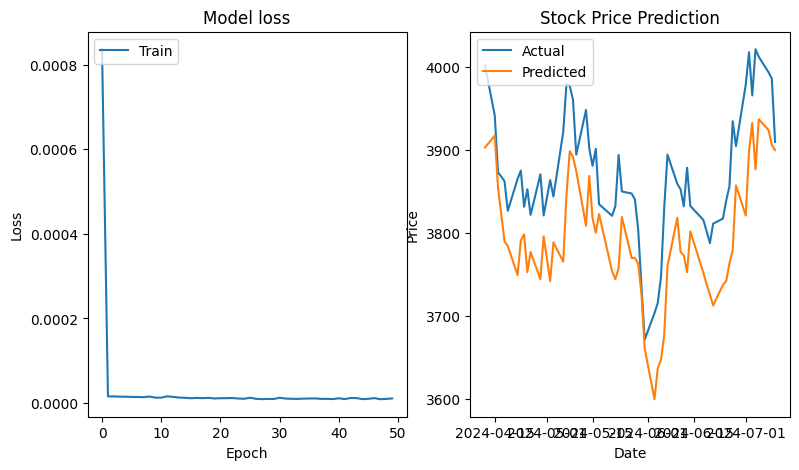

In [ ]:
plt.figure(figsize=(14, 5))
import pandas as pd

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot actual vs predicted prices for past 60 days
plt.subplot(1, 3, 2)
plt.plot(data.index[-len(y_test[-60:]):], scaler.inverse_transform(y_test[-60:].reshape(-1, 1)), label='Actual')
plt.plot(data.index[-len(y_test[-60:]):], scaler.inverse_transform(model.predict(X_test[-60:])), label='Predicted')
plt.title('Stock Price Prediction')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['Actual', 'Predicted'], loc='upper left')